In [1]:
%pip install --upgrade --quiet pip setuptools wheel matplotlib seaborn
%pip install --upgrade --quiet  langchain langchain-openai faiss-cpu tiktoken crate 'crate[sqlalchemy]' pandas jq 
%pip install --use-pep517 --quiet python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Evaluate RAG search with CrateDB vector, fulltext, fusion and OpenAI

## Setup environment variables

In [3]:
import os

from dotenv import load_dotenv

load_dotenv()

True

## setup embeddings

In [4]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
len(embeddings.embed_query("a"))

1536

In [5]:
conn_url = "crate://{user}:{password}@{server}".format(
    user=os.environ["CRATEDB_USER"],
    password=os.environ["CRATEDB_PASS"],
    server=os.environ["CRATEDB_SERVER"],
)
conn_url

'crate://crate:@localhost:4200'

In [6]:
# open file
from langchain_community.document_loaders import JSONLoader, DirectoryLoader


def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["source_url"] = record.get("url")
    metadata["source_title"] = record.get("title")

    if "source" in metadata:
        metadata["source"] = metadata["source_url"]

    return metadata


loader = DirectoryLoader(
    './',
    glob="everything-*.json",
    loader_cls=JSONLoader,
    loader_kwargs={
        "jq_schema": ".[]",
        "text_content": False,
        "content_key": "html",
        "metadata_func": metadata_func,
    }
)

data = loader.load()
# data[:1]

In [7]:
# split documents
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
    ],
    chunk_size=500,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)

docs_splits = text_splitter.split_documents(data)
# docs_splits[:2]

## RAG search, indexing pipeline    

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

In [9]:
from rag.vectorstore.crate import CrateVectorStore

vectorstore = CrateVectorStore.from_documents(
    # assumes that data was imported already
    # allow faster recomputation of notebook, without need of reindexing
    documents=[],
    # documents=docs_splits,
    embedding=embeddings,
    database_kwargs={
        "database_uri": conn_url,
    },
    # vectorstore_kwargs={
    #    "drop_if_exists" : True,
    # },
)
vectorstore

In [10]:
from langchain.retrievers import EnsembleRetriever

retriever_a = vectorstore.as_retriever(
    search_kwargs={'k': 10, 'fetch_k': 100, "algorith": "knn"}
)

retriever_b = vectorstore.as_retriever(
    search_kwargs={'k': 10, 'fetch_k': 100, "algorith": "fulltext"}
)

retriever_c = EnsembleRetriever(
    retrievers=[
        retriever_a,
        retriever_b
    ],
    weights=[0.5, 0.5],
)

In [11]:
import json

In [12]:
template = """Answer the question based only on the context, if possible use links to reference the source, use markdown, avoid answering when the context and question are not related.

today date is 2024 April 3rd

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()


def format_docs(docs):
    breakpoint()
    return json.dumps([{"text": d.page_content, "source": d.metadata.get('source')} for d in docs])


chain_a = (
        {"context": retriever_a | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
)

chain_b = (
        {"context": retriever_b | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
)

chain_c = (
        {"context": retriever_c | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
)

# result = chain.invoke("How to limit permissions?")
# result = chain.invoke(" How AWS marketplace works, and why I cannot see deployment in my account?")
# result = chain.invoke("What are edge regions and how to use them?")
result = chain_a.invoke("Write me example of using blobs?")
# result = chain.invoke("How to use BLOB store in CrateDB? and what are the benefits?")
result


'To use blobs, you can create a blob table in CrateDB using the following SQL statement in the Crate Shell:\n\n```sh\ncrash -c "create blob table myblobs clustered into 3 shards with (number_of_replicas=1)"\n```\n\nThis will allow you to store and manage binary large objects (BLOBs) efficiently through CrateDB. You can find more information about using CrateDB as a blobstore [here](https://cratedb.com/blog/using-crate-as-a-blobstore).'

In [13]:
from IPython.display import display, Markdown

display(Markdown(result))

To use blobs, you can create a blob table in CrateDB using the following SQL statement in the Crate Shell:

```sh
crash -c "create blob table myblobs clustered into 3 shards with (number_of_replicas=1)"
```

This will allow you to store and manage binary large objects (BLOBs) efficiently through CrateDB. You can find more information about using CrateDB as a blobstore [here](https://cratedb.com/blog/using-crate-as-a-blobstore).

## Evaluation

In [14]:
questions = [
    "Write me example of using blobs?",
    "How to use BLOB store in CrateDB? and what are the benefits?",
    "How to limit permissions?",
    "How AWS marketplace works, and why I cannot see deployment in my account?",
    "What are edge regions and how to use them?",
    "What are recent blog posts about CrateDB?",
    "Write me example python code to use CrateDB?",
    "Write me example golang code to use CrateDB?",
    "create RAG search with CrateDB and OpenAI?",
    "how to alter table and add fulltext index?",
    "how to alter table and add vector type field that allows for KNN search?",
    "create table with fields ID, name, vector, and index vector field for KNN search?",
    "What are limits and limitations of CrateDB?",
    "What are the benefits of using CrateDB?",
    "Does index creation block write operations?",
    "Does crate supports conditional indices",
    "How to create ID field that is autoincremented?",
    "how to create analysers for fulltext search?",
    "give me information about password and admin",
    "Shared file system implementation of the BlobStoreRepository",
    "Is Cloud UI opensource?",
    "How to do fusion search and connect vector search with fulltext search",
    "How to MATH fulltext "
    "Benchmarks of CrateDB",
]

In [80]:
from langchain.evaluation import load_evaluator

# from langchain.evaluation.criteria import Criteria
# 
# criteria = [
#     Criteria.COHERENCE,
#     Criteria.RELEVANCE,
#     Criteria.DETAIL,
#     Criteria.HARMFULNESS,
#     Criteria.HELPFULNESS,
# ]

criteria2 = {
    "runnable": "Software engineer who is looking for information can copy and paste the code and it should work",
    "relevance": "The answer is relevant to the question",
    "grounded": "The answer links to the source of the information",
    "coherence": "The answer is coherent and makes sense",
    "detail": "The answer is detailed and provides enough information",
    "helpfulness": "The answer is helpful and provides value",
    "direct": "The answer directly answers the question",
    "code": "The answer contains code that can be copied and pasted",
    "reference": "The answer contains reference to the source in form of URL",
}

evaluator = load_evaluator("pairwise_string", criteria=criteria2)

In [81]:
question = "Write me example of using blobs?"
prediction = chain_a.invoke(question)
prediction_b = chain_b.invoke(question)

ev = evaluator.evaluate_string_pairs(
    prediction=prediction,
    prediction_b=prediction_b,
    input=question
)

In [82]:
ev

{'reasoning': "Both assistants provided a relevant and coherent response to the user's question. They both provided a runnable code example and referenced the same source for their information. However, Assistant A provided a more detailed explanation of what the code does, explaining that it creates a blob table named 'myblobs' with 3 shards and 1 replica. This additional detail makes Assistant A's response more helpful and direct in answering the user's question. Therefore, Assistant A is the better assistant in this case. \n\nFinal Verdict: [[A]]",
 'value': 'A',
 'score': 1}

In [111]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List


class InferredRational(BaseModel):
    rationale: str = Field(description="rational of the labeler")
    category: str = Field(description="category used for evaluation")
    score: float = Field(
        description="Score -1.5 to 1.5. Where -1.5 is below expectations in the rational category, and 1.5 is above expectations in the rational category.")


class RationalList(BaseModel):
    list: List[InferredRational] = Field(description="list of rationals used to asses quality by labeler")


parser_ret = JsonOutputParser(pydantic_object=RationalList)

prompt_reg = PromptTemplate(
    template="Extract labeler rational following criterias {criterias}.\n{format_instructions}\n{reasoning}\n",
    input_variables=["reasoning"],
    partial_variables={
        "format_instructions": parser_ret.get_format_instructions(),
        "criterias": json.dumps(criteria2, indent=2)
    },
)

chain_reasoning_extract = prompt_reg | model | parser_ret


def extract_reasoning(reasoning) -> RationalList:
    try:
        return chain_reasoning_extract.invoke({"reasoning": reasoning})
    except BaseException as e:
        return None

In [107]:
extract_reasoning(ev['reasoning'])

{'list': [{'rationale': 'Provided a detailed explanation of the code',
   'category': 'detail',
   'score': 1.5},
  {'rationale': 'Answer is relevant to the question',
   'category': 'relevance',
   'score': 1.0},
  {'rationale': 'Answer is coherent and makes sense',
   'category': 'coherence',
   'score': 1.0},
  {'rationale': 'Answer is helpful and provides value',
   'category': 'helpfulness',
   'score': 1.0},
  {'rationale': 'Answer directly answers the question',
   'category': 'direct',
   'score': 1.0},
  {'rationale': 'Answer contains code that can be copied and pasted',
   'category': 'code',
   'score': 1.0},
  {'rationale': 'Answer contains reference to the source in form of URL',
   'category': 'reference',
   'score': 1.0}]}

In [112]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List


class TaggedQuestion(BaseModel):
    question: str = Field(description="the original question")
    tags: List[str] = Field(description="the list of tags that best categorize the question")


class TaggedQuestionList(BaseModel):
    list: List[TaggedQuestion] = Field(description="list of categorized questions")


parser_cat = JsonOutputParser(pydantic_object=TaggedQuestionList)

prompt_cat = PromptTemplate(
    template="Categorize question {questions}.\n{format_instructions}\n\n",
    input_variables=["reasoning"],
    partial_variables={
        "format_instructions": parser_cat.get_format_instructions(),
        "questions": json.dumps(questions, indent=2)
    },
)

chain_tag_question = prompt_cat | model | parser_cat


def categorise_questions(questions: List[str]) -> TaggedQuestionList:
    try:
        return chain_tag_question.invoke({"questions": questions})
    except BaseException as e:
        return None

In [110]:
categorised_questions = categorise_questions(questions)
categorised_questions

{'list': [{'question': 'Write me example of using blobs?',
   'tags': ['Blob Usage']},
  {'question': 'How to use BLOB store in CrateDB? and what are the benefits?',
   'tags': ['Blob Store', 'CrateDB', 'Benefits']},
  {'question': 'How to limit permissions?', 'tags': ['Permissions']},
  {'question': 'How AWS marketplace works, and why I cannot see deployment in my account?',
   'tags': ['AWS Marketplace', 'Deployment']},
  {'question': 'What are edge regions and how to use them?',
   'tags': ['Edge Regions', 'Usage']},
  {'question': 'What are recent blog posts about CrateDB?',
   'tags': ['CrateDB', 'Blog Posts']},
  {'question': 'Write me example python code to use CrateDB?',
   'tags': ['Python', 'CrateDB', 'Code Example']},
  {'question': 'Write me example golang code to use CrateDB?',
   'tags': ['Golang', 'CrateDB', 'Code Example']},
  {'question': 'create RAG search with CrateDB and OpenAI?',
   'tags': ['RAG Search', 'CrateDB', 'OpenAI']},
  {'question': 'how to alter table an

In [113]:
from typing import List
# setup LLM Comparator
import llm_comparator as llc
import concurrent.futures

def build_example(index: int, question: TaggedQuestion, chain_a, chain_b, raters=3):
    prediction = chain_a.invoke(question['question'])
    prediction_b = chain_b.invoke(question['question'])

    individual_rater_scores: List[llc.RaterScore] = []

    # parallelize
    with concurrent.futures.ThreadPoolExecutor() as executor:
        evaluations = list(executor.map(
            lambda i: evaluator.evaluate_string_pairs(
                prediction=prediction if i % 2 == 0 else prediction_b,
                prediction_b=prediction_b if i % 2 == 0 else prediction,
                input=question['question']
            ),
            range(raters * 2)
        ))

        for i, ev in enumerate(evaluations):
            is_flipped = i % 2 == 1
            # make score that is between 0 and 1, to be between -1.5 and 1.5
            score = (ev['score'] - 0.5) * 3
            if is_flipped:
                score = -score

            individual_rater_scores.append(
                llc.RaterScore(
                    is_flipped=is_flipped,
                    score=score,
                    rationale=ev['reasoning'],
                    rating_label=ev['value']
                )
            )

    avg_score = sum([r.score for r in individual_rater_scores]) / len(individual_rater_scores)

    return llc.Example(
        index=index,
        input_text=question['question'],
        tags=question["tags"],
        output_text_a=prediction,
        output_text_b=prediction_b,
        score=avg_score,
        custom_fields={},
        individual_rater_scores=individual_rater_scores,
    )


metadata = llc.Metadata(
    source_path="Compare RAG search with CrateDB vector, fulltext, fusion and OpenAI",
    custom_fields_schema=[]
)

models: List[llc.Model] = [
    llc.Model(
        name="A",
    ),
    llc.Model(
        name="B",
    ),
]

examples: List[llc.Example] = [build_example(i, x, chain_a, chain_b) for i, x in
                               enumerate(categorised_questions['list'])]




In [119]:
rationale_clusters: List[llc.RationaleCluster] = [
    llc.RationaleCluster(
        title="provide more details",
    ),
    llc.RationaleCluster(
        title="is more engaging",
    ),
    llc.RationaleCluster(
        title="directly answers the question",
    ),
    llc.RationaleCluster(
        title="has more references",
    ),
    llc.RationaleCluster(
        title="has code examples",
    ),
]



In [114]:
from numpy import dot
from numpy.linalg import norm


def measure_similarities(rational_cluster_emb: List[List[float]], rational_emb: List[float]) -> List[List[float]]:
    b = rational_emb
    return [
        dot(a, b) / (norm(a) * norm(b)) for a in rational_cluster_emb
    ]



In [115]:
# enhance each example with rationale_list. 
for example in examples:
    rationale_clusters_emb_list = embeddings.embed_documents([r.title for r in rationale_clusters])

    with concurrent.futures.ThreadPoolExecutor() as executor:
        extracted_list = list(executor.map(
            lambda rater_score: extract_reasoning(rater_score.rationale),
            example.individual_rater_scores
        ))
        for extracted in extracted_list:
            if extracted and 'list' in extracted and len(extracted['list']) > 0:
                example.rationale_list = [llc.Rational(
                    rationale=r['rationale'],
                    paraphrased_rationales=[],
                    similarities=measure_similarities(rationale_clusters_emb_list,
                                                      embeddings.embed_query(r['rationale'])),
                ) for r in extracted['list']]


In [120]:
llcset = llc.LLMComparatorData(
    metadata=metadata,
    models=models,
    examples=examples,
    rationale_clusters=rationale_clusters,
)

with open("eval.json", "w") as f:
    f.write(llcset.to_json())

In [19]:
from random import random


def eval(questions, chain_a, chain_b, aname="A", bname="B", cname=None):
    evaluation_results = []

    for question in questions:
        prediction = chain_a.invoke(question)
        prediction_b = chain_b.invoke(question)
        # prediction_c = chain_c.invoke(question)

        # swap prediction to avoid bias in evaluator

        choice = random() > 0.5
        if choice:
            prediction, prediction_b = prediction_b, prediction

        ev = evaluator.evaluate_string_pairs(
            prediction=prediction,
            prediction_b=prediction_b,
            input=question
        )

        if choice:
            ev = {
                "value": {"A": bname, "B": aname, None: cname}[ev["value"]],
                "score": ev["score"],
                "reasoning": "Swapped prediction: {}".format(ev["reasoning"])
            }

        evaluation_results.append({
            "choice": choice,
            "candidates": ",".join([aname, bname, "None"]),
            "question": question,
            f"prediction_{aname}": prediction if choice else prediction_b,
            f"prediction_{bname}": prediction_b if choice else prediction,
            **ev
        })

    return evaluation_results


In [ ]:
import pandas as pd

evaluation_results_ab_df = pd.DataFrame(eval(questions, chain_a, chain_b, aname="A", bname="B"))
evaluation_results_ab_df

In [ ]:
evaluation_results_ac_df = pd.DataFrame(eval(questions, chain_a, chain_c, aname="A", bname="C"))
evaluation_results_ac_df

In [ ]:
evaluation_results_bc_df = pd.DataFrame(eval(questions, chain_b, chain_c, aname="B", bname="C"))
evaluation_results_bc_df

# Analysis of evaluation results
- Which variant was preferred more?
- What is probability that people presented with a variant A over B will be more happy?
- Which prediction variant on average performed better?
- What is distribution of scores for each prediction variant?

## Which variant was preferred more? as percentage

In [ ]:
total = len(questions)
# value can be A, B, None, None means that both predictions are equal, show None as C
# dived by total to get percentage contribution from all evaluations 
# multiply by 100 to get percentage
ab_res = evaluation_results_ab_df['value'].fillna("X").value_counts() / total * 100
ab_res

In [ ]:
ac_res = evaluation_results_ac_df['value'].fillna("X").value_counts() / total * 100
ac_res

In [ ]:
bc_res = evaluation_results_bc_df['value'].fillna("X").value_counts() / total * 100
bc_res

In [49]:
joined = pd.concat([evaluation_results_bc_df,
                    evaluation_results_ac_df,
                    evaluation_results_ab_df], axis=0)
joined.fillna("None", inplace=True)
joined

,choice,candidates,question,prediction_B,prediction_C,value,score,reasoning,prediction_A
0,True,"B,C,None",Write me example of using blobs?,"To use blobs in Crate, you first need to creat...","To upload a blob, you can issue a PUT request ...",C,1.0,Swapped prediction: Both assistants provide re...,None
1,False,"B,C,None",How to use BLOB store in CrateDB? and what are...,"To use BLOB store in CrateDB, you can store bi...","To use BLOB store in CrateDB, you can store bi...",B,0.0,Both Assistant A and Assistant B provided cohe...,None
2,True,"B,C,None",How to limit permissions?,"To limit permissions in CrateDB, users can uti...","To limit permissions, you can use Role-Based A...",C,1.0,Swapped prediction: Both assistants provide co...,None
3,True,"B,C,None","How AWS marketplace works, and why I cannot se...",To deploy a cluster on CrateDB Cloud via AWS M...,The AWS Marketplace works by allowing users to...,C,1.0,Swapped prediction: Both assistants provide co...,None
4,False,"B,C,None",What are edge regions and how to use them?,Edge regions are custom regions that can be cr...,Edge regions are components of a deployed Edge...,A,1.0,Both Assistant A and Assistant B provide coher...,None
...,...,...,...,...,...,...,...,...,...
18,True,"A,B,None",give me information about password and admin,"Based on the provided text sources, passwords ...",None,B,1.0,Swapped prediction: Both Assistant A and Assis...,"Based on the provided context, password authen..."
19,True,"A,B,None",Shared file system implementation of the BlobS...,The BlobStoreRepository shared file system imp...,None,A,0.0,Swapped prediction: Assistant B's response is ...,The information provided does not contain deta...
20,False,"A,B,None",Is Cloud UI opensource?,"Based on the provided context, it seems that t...",None,B,0.0,Assistant A and Assistant B both provide coher...,"Based on the context provided, the Cloud UI me..."
21,True,"A,B,None",How to do fusion search and connect vector sea...,To do fusion search and connect vector search ...,None,None,0.5,Swapped prediction: Both Assistant A and Assis...,To perform fusion search and connect vector se...


In [53]:
# statistics
joined['value'].describe()

count     69
unique     4
top        A
freq      26
Name: value, dtype: object

<Axes: xlabel='value'>

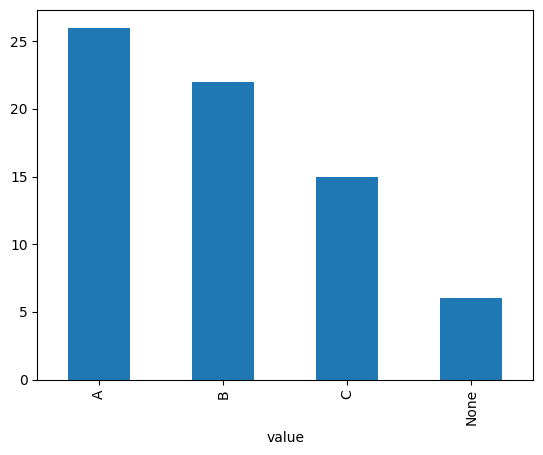

In [52]:
joined['value'].value_counts().plot.bar()

In [54]:
joined.to_csv("joined.csv")